# Интернет магазин: Аналитика пользователей по группам A/B и проверка гипотез

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

## Часть 1: Приоритизация гипотез

Импортируем необходимые библиотеки и изучим датасет с гипотезами

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<img src="https://cms.thisisnovos.com/wp-content/uploads/Screenshot-2022-11-10-at-10.49.48.png" style="width:250px;"/>  
<img src="https://productfolio.com/wp-content/uploads/rice-scoring.png" style="width:250px;"/>  

Применим фреймфорк **ICE**

In [3]:
hypothesis['ICE'] = (hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']

hypothesis.sort_values(by='ICE', ascending=False).head(1)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2


Самая приоритетная гипотеза по фреймворку ICE: ***Запустить акцию, дающую скидку на товар в день рождения***  
  
Применим фреймворк **RICE**

In [4]:
hypothesis['RICE'] = (hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']

hypothesis.sort_values(by='RICE', ascending=False).head(1)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0


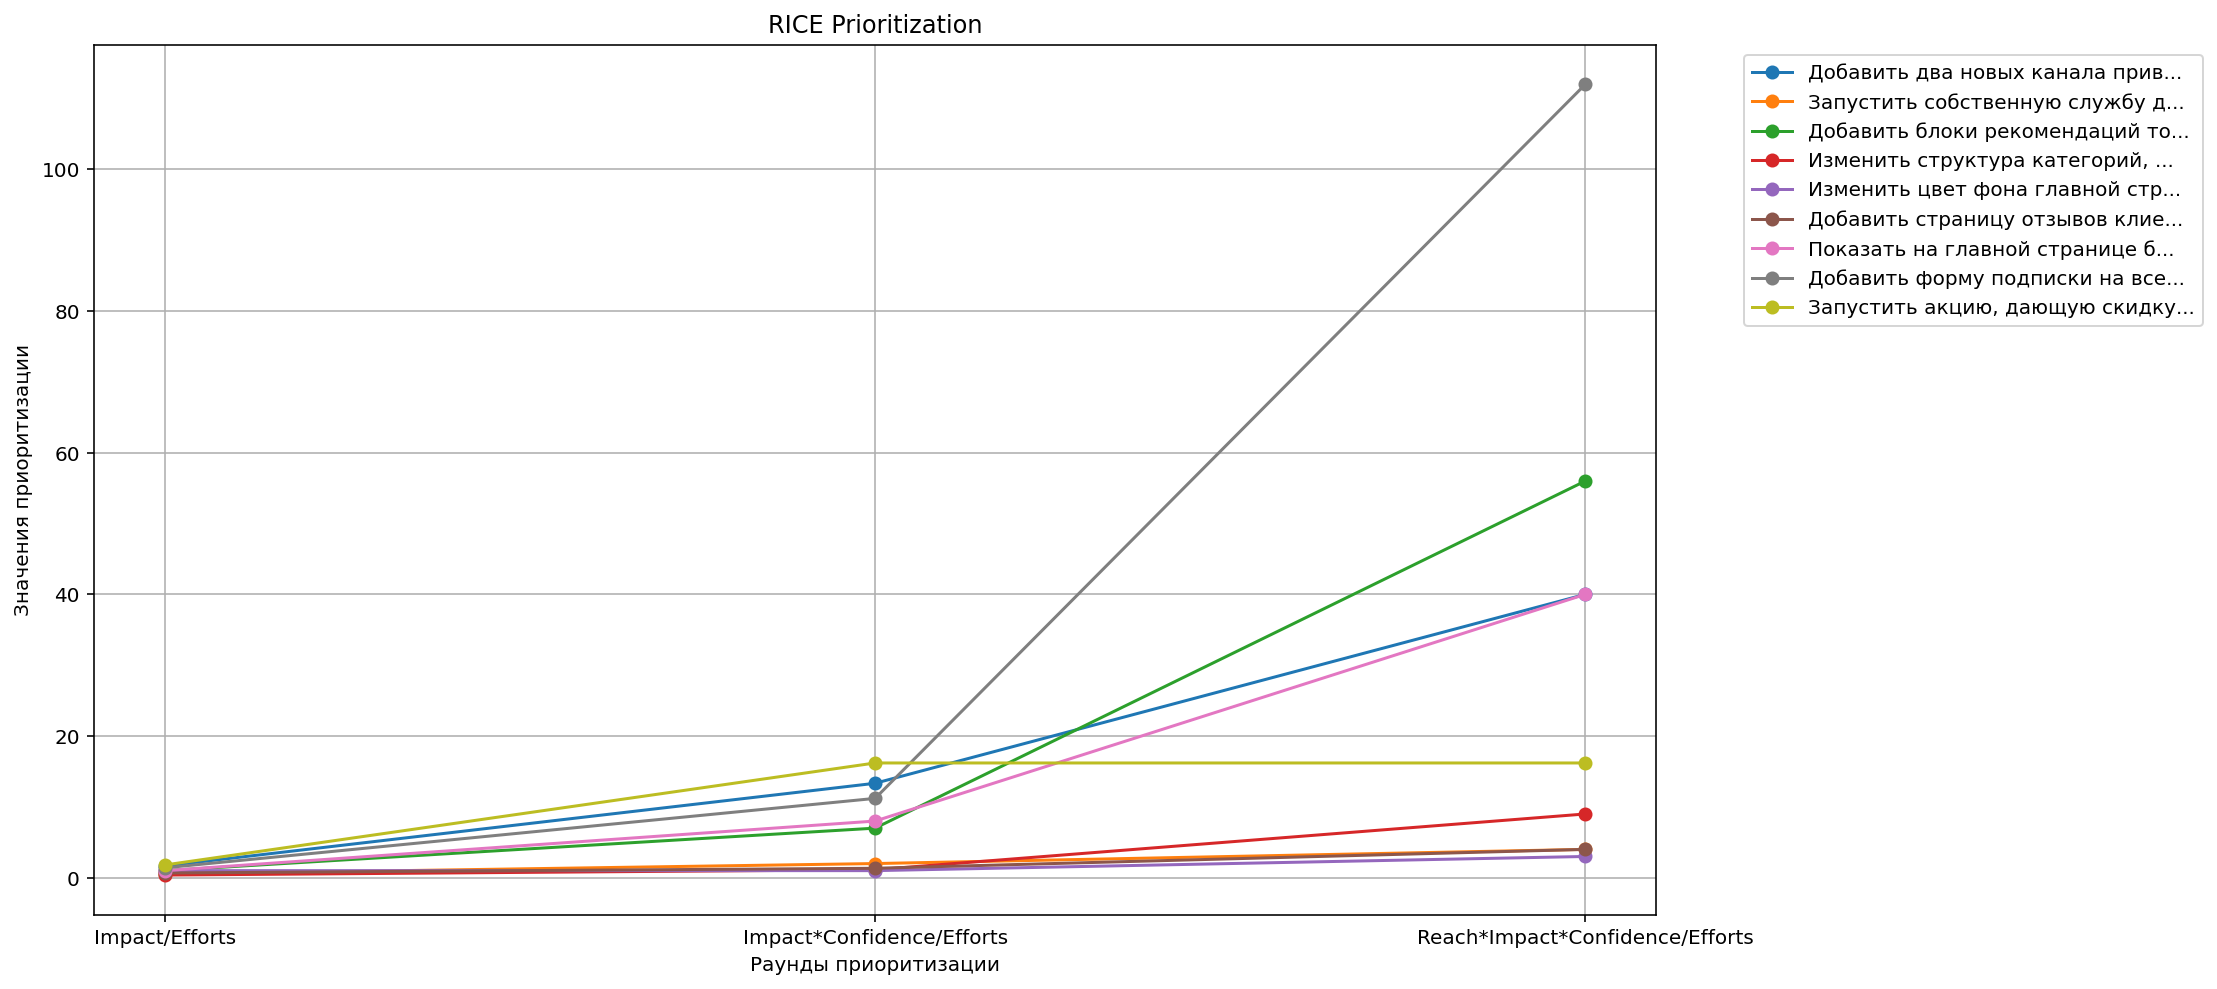

In [5]:
def plot_prioritization(hypothesis, title):
    rounds = ['Impact/Efforts', 'Impact*Confidence/Efforts', 'Reach*Impact*Confidence/Efforts']
    
    plt.figure(figsize=(14, 8))
    
    for index, row in hypothesis.iterrows():
        values = [
            row['Impact'] / row['Efforts'],
            (row['Impact'] * row['Confidence']) / row['Efforts'],
            (row['Reach'] * row['Impact'] * row['Confidence']) / row['Efforts']
        ]
        plt.plot(rounds, values, marker='o', label=row['Hypothesis'][:30] + '...')
    
    plt.title(title)
    plt.xlabel('Раунды приоритизации')
    plt.ylabel('Значения приоритизации')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# График для RICE
plot_prioritization(hypothesis, 'RICE Prioritization')

Самая приоритетная гипотеза по фреймворку RICE: ***Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок***

Приоритизация гипотез изменилась, поскольку фреймворк RICE помимо Impact, Confidence и Efforts учитывает еще и Reach.

## Часть 2: Анализ A/B теста

### Предобработка данных

Изучим датасеты с заказами и посетителями

In [6]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
display(orders)

visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
display(visitors)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Проверим на наличие полных дубликатов

In [7]:
orders.duplicated().sum()

0

In [8]:
visitors.duplicated().sum()

0

Проверим на пропуски и типы данных

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков нет. Поменяем в обоих датасетах тип данных для даты с **object** на **datetime**

In [11]:
orders['date'] = pd.to_datetime(orders['date'])

visitors['date'] = pd.to_datetime(visitors['date'])

Проверим, есть ли пользователи, попавшие сразу в 2 группы теста

In [12]:
group_a = orders[orders['group'] == 'A']
group_b = orders[orders['group'] == 'B']
group_ab = group_a.merge(group_b, how='inner', on='visitorId')
ab_ids = group_ab['visitorId'].unique()

In [13]:
print('Кол-во покупателей, попавших сразу в 2 группы теста:', len(ab_ids))
print('Это', round(len(ab_ids)/len(orders['visitorId'].unique())*100, 2), '%')
print('Кол-во заказов у этих покупателей:', len(group_ab['visitorId']))
print('Это', round(len(group_ab['visitorId'])/len(orders['transactionId'].unique())*100, 2), '%')
print('Всего посетителей за все время проведения теста:', visitors['visitors'].sum())
print('Доля заказов пользователей из 2 групп одновременно в общей массе посетителей:', round(len(group_ab['visitorId'])/visitors['visitors'].sum()*100, 2), '%')

Кол-во покупателей, попавших сразу в 2 группы теста: 58
Это 5.63 %
Кол-во заказов у этих покупателей: 183
Это 15.29 %
Всего посетителей за все время проведения теста: 37652
Доля заказов пользователей из 2 групп одновременно в общей массе посетителей: 0.49 %


Один и тот же пользователь не должен присутствовать в 2 группах одновременно, это может сильно исказить результаты A/B теста. Было принято решение удалить таких пользователей из датасета **orders**. Из датасета **visitors** удалить их будет не так просто, однако такие пользователи составляют меньше 0.5% от общей массы посетителей, что можно считать приемлемой погрешностью, так что оставим датасет **visitors** в исходном виде.  
  
Скопируем оригинальный датасет **orders** в другую переменную на всякий случай, а **orders** перезапишем, убрав id пользователей, попавших в 2 группы одновременно.

In [14]:
orders_raw = orders.copy()
orders = orders.query('visitorId not in @ab_ids')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Посмотрим, сколько посетителей в группах A и B

In [15]:
print('Всего посетителей в группе A:', visitors[visitors['group'] == 'A']['visitors'].sum())
print('Всего посетителей в группе B:', visitors[visitors['group'] == 'B']['visitors'].sum())
round((visitors[visitors['group'] == 'B']['visitors'].sum()-visitors[visitors['group'] == 'A']['visitors'].sum())/visitors[visitors['group'] == 'A']['visitors'].sum()*100, 2)

Всего посетителей в группе A: 18736
Всего посетителей в группе B: 18916


0.96

Различие не превышает 1%, что считается допустимым.  
  
Проверим, есть ли дубликаты в id транзакций

In [16]:
orders['transactionId'].duplicated().sum()

0

## Выручка. Графики

Построим график кумулятивной выручки по группам

In [17]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                                    .agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 
                                          'visitorId': 'nunique', 'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                                      .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
5,2019-08-03,B,54,53,288850,1803
6,2019-08-04,A,77,71,388030,2562
7,2019-08-04,B,68,66,385740,2573
8,2019-08-05,A,99,92,474413,3318
9,2019-08-05,B,89,87,475648,3280


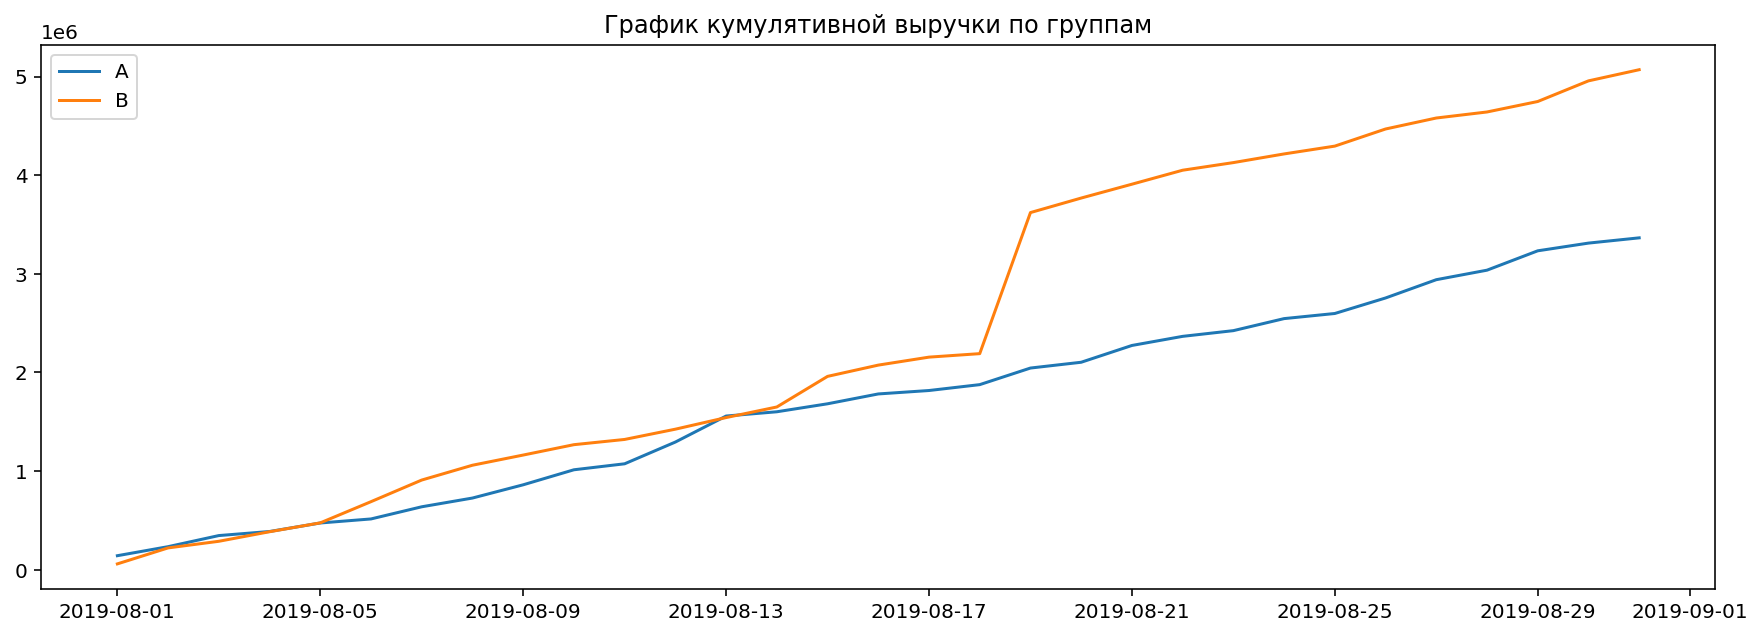

In [18]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам');

Выручка +- равномерно увеличивается в течение всего теста, график группы B после середины теста обгоняет группу A, он резко растет в одной точке, что может быть обусловлено выбросами

## Средний чек. Графики

Построим график кумулятивного среднего чека по группам

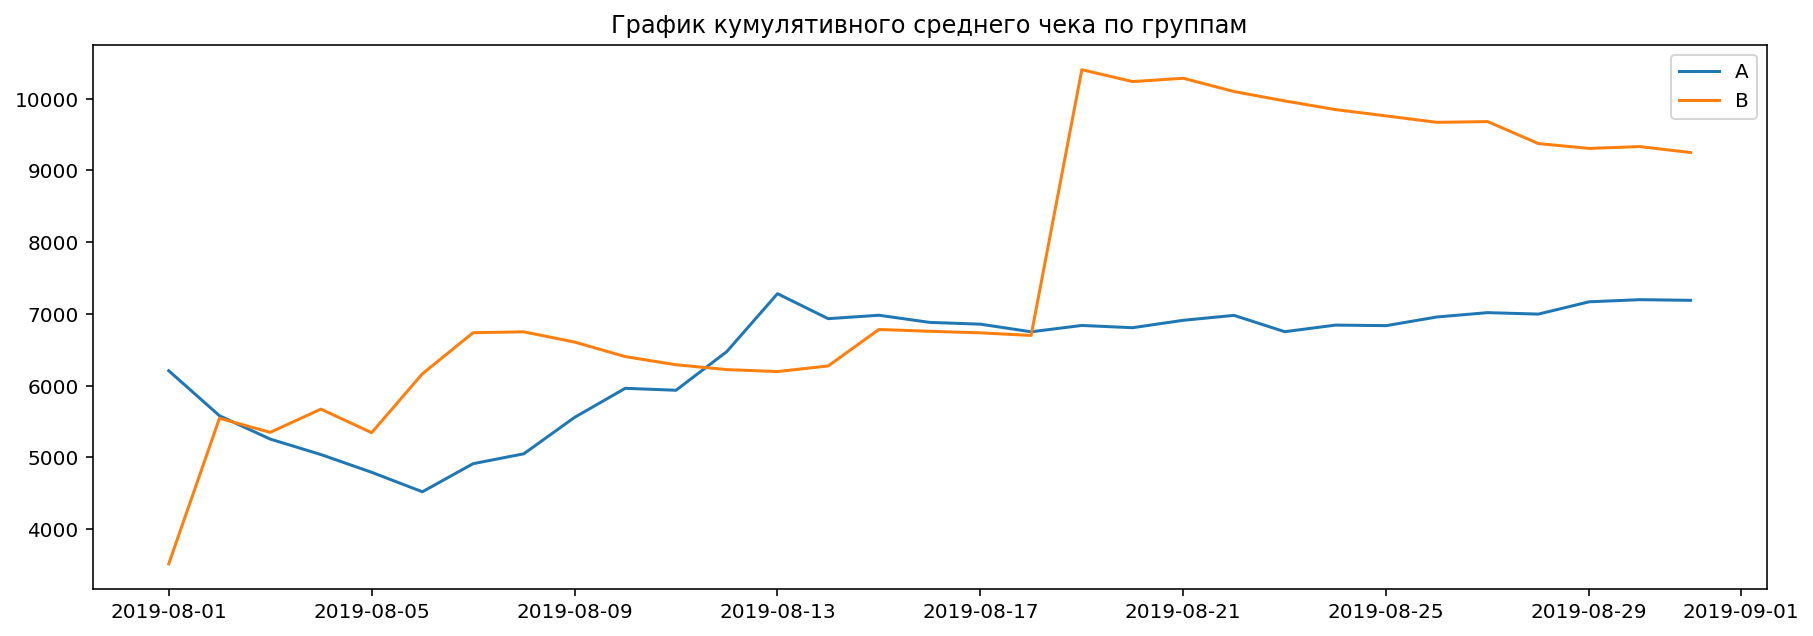

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам');

График среднего чека группы B резко растет в том же месте, что и график выручки, видимо в этот день сделали аномально дорогие заказы, либо заказов было аномально много

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

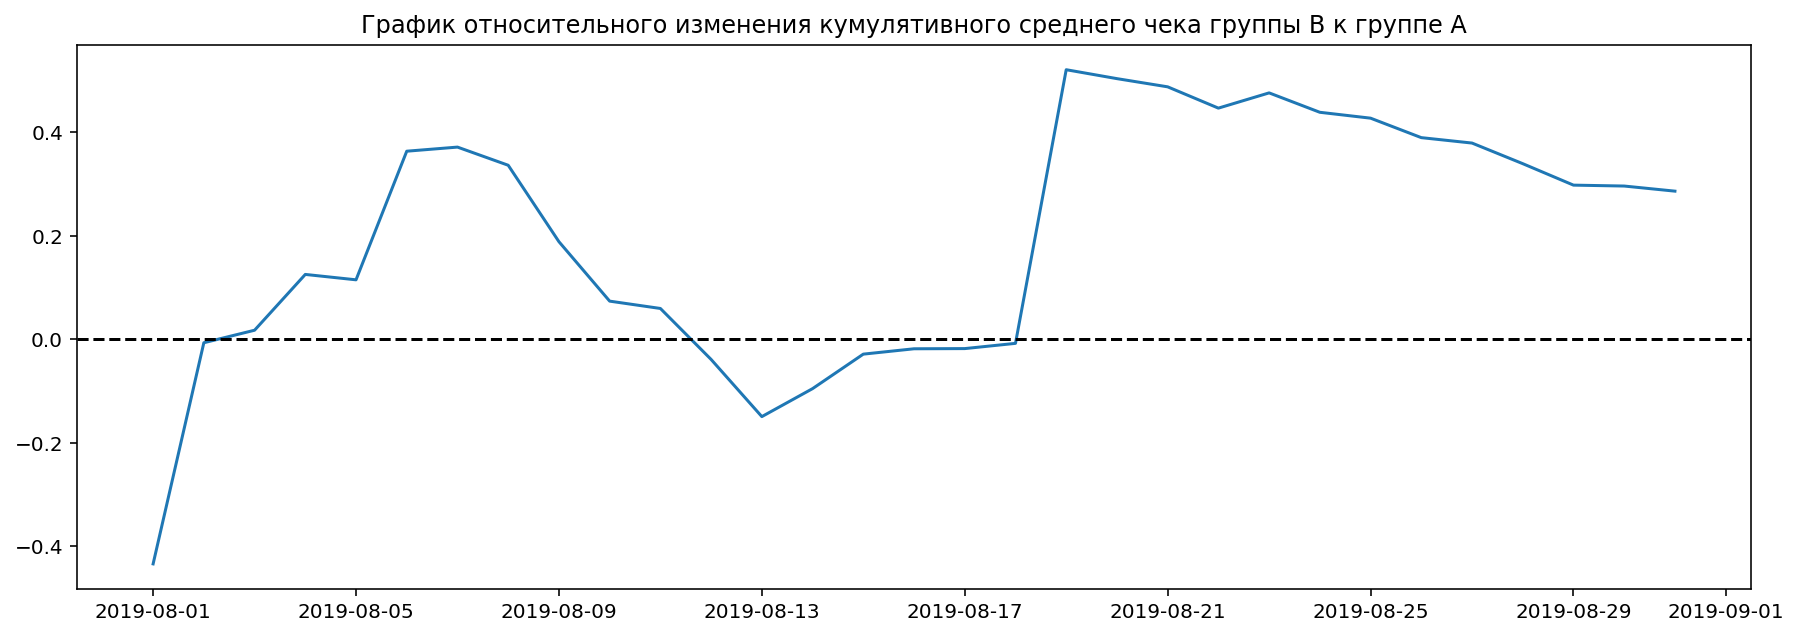

In [20]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on=['date'], right_on=['date'], 
                                                   how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1, label="Относительный прирост B к A")
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');

Есть несколько точек с резкими скачками, вероятнее всего вследствие выбросов

### Среднее количество заказов на посетителя. Графики

Построим график кумулятивного среднего количества заказов на посетителя по группам

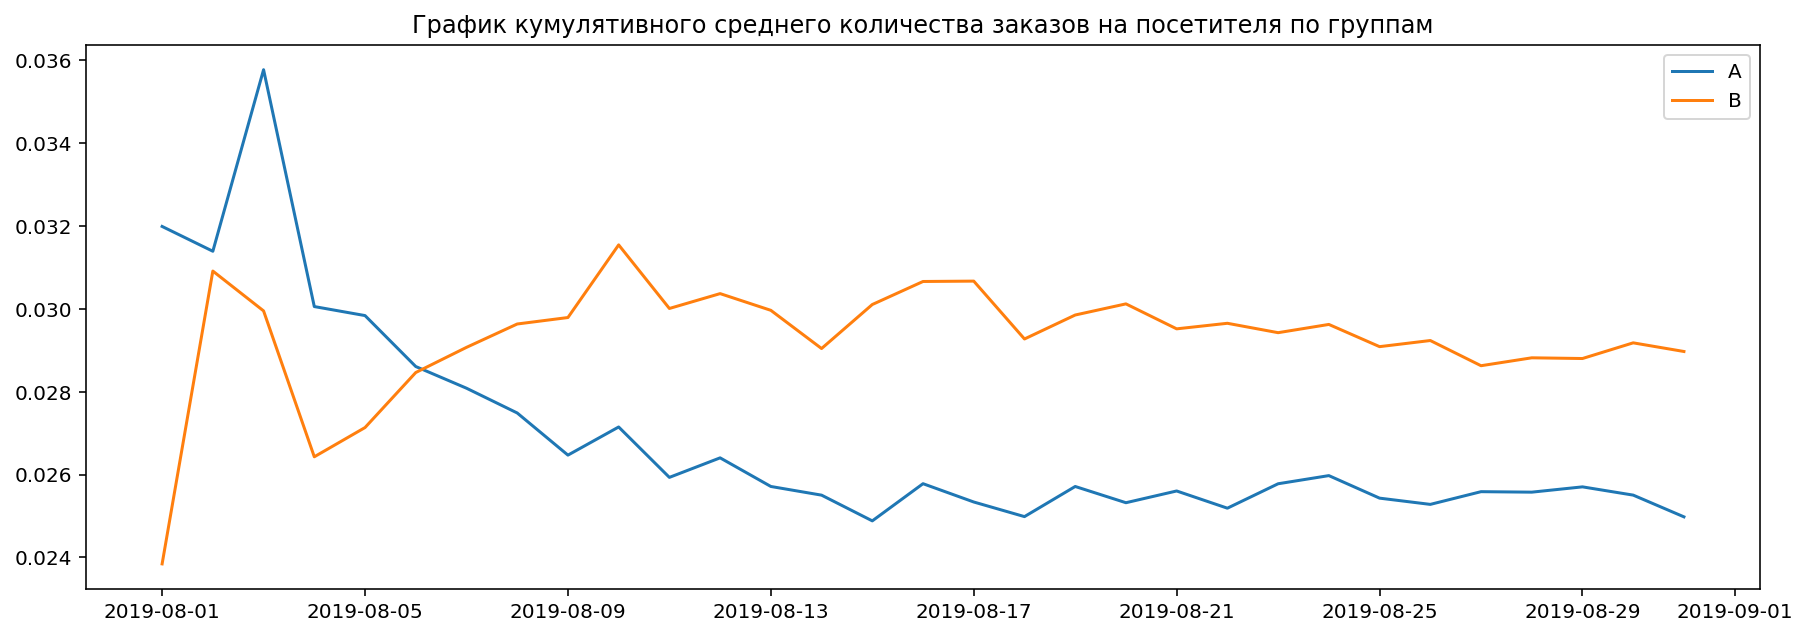

In [21]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(15, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам');

В течение почти всего теста группа B стабильно и равномерно лучше группы A по количеству заказов на посетителя, есть лишь резкие скачки в начале

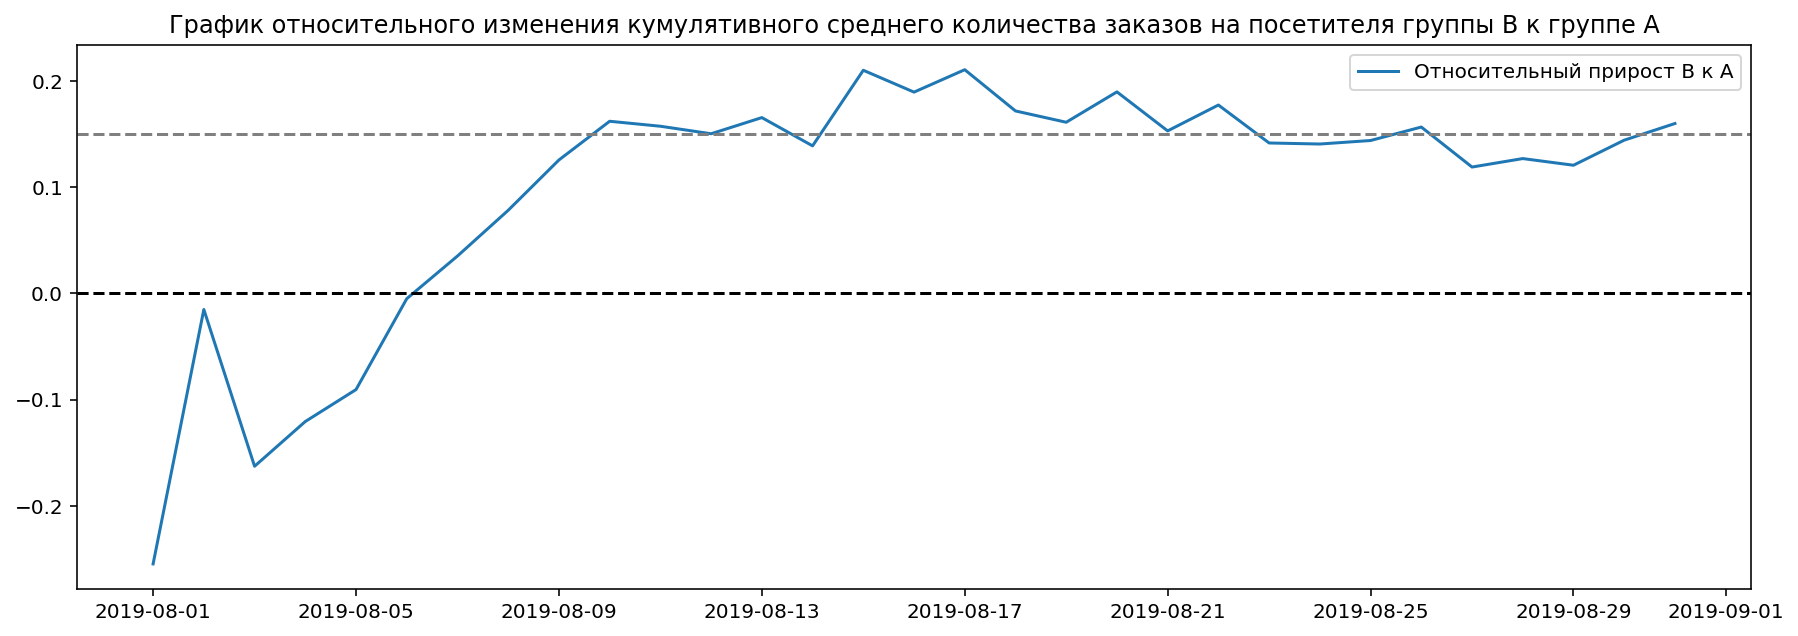

In [22]:
mergedCumulativeConversion = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], 
                                                                          left_on='date', right_on='date', how='left', 
                                                                           suffixes=['A', 'B'])

plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeConversion['date'], mergedCumulativeConversion['conversionB']/mergedCumulativeConversion['conversionA']-1, label="Относительный прирост B к A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A');

Скачки в начале теста вероятнее всего обусловлены небольшим размером выборки, чем больше становится данных, тем меньше разброс и стабильнее доминация группы B, которая зафиксировалась на уровне +~15% относительно группы A

### Аномалии и выбросы

Построим диаграмму рассеяния для количества заказов по пользователям

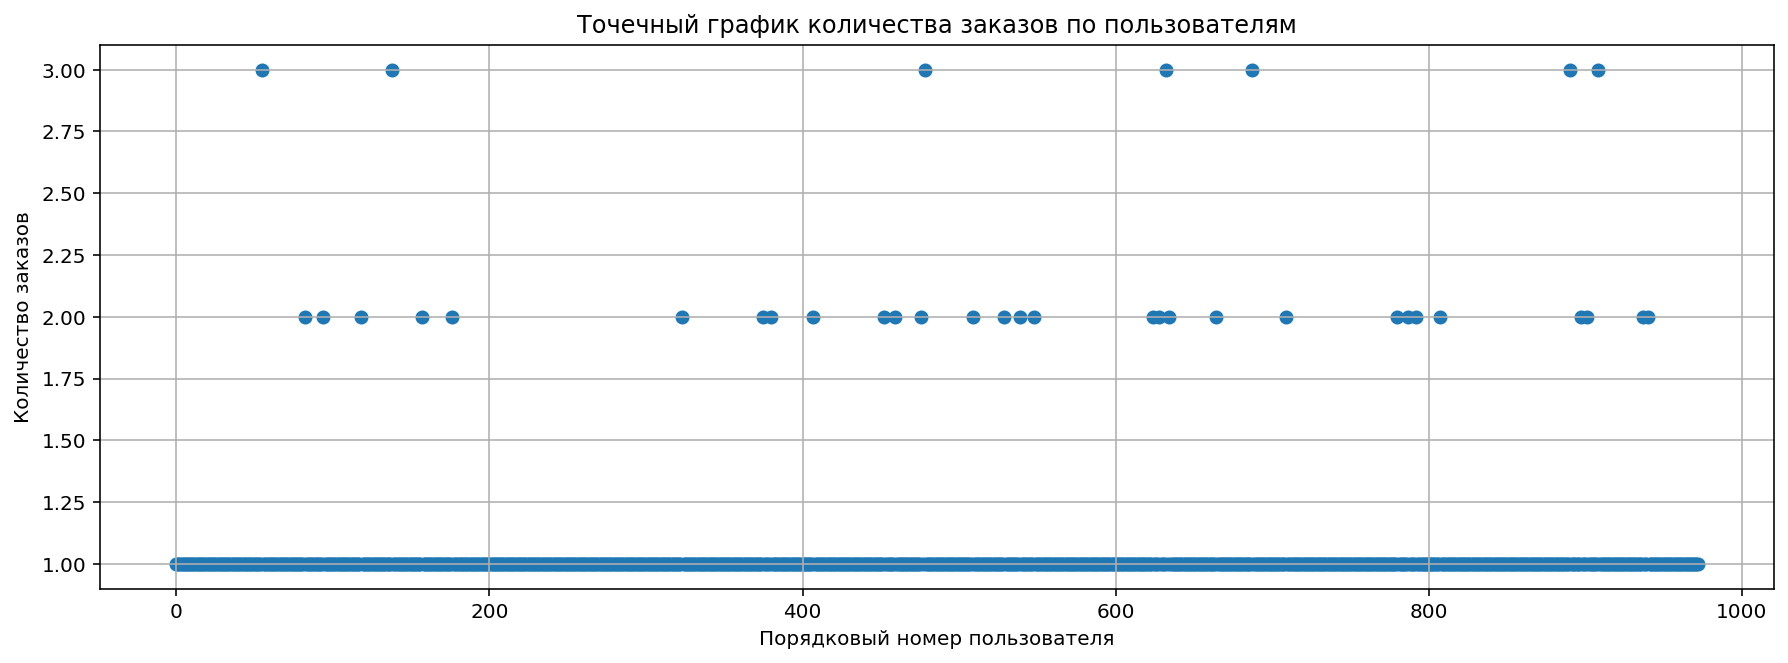

In [23]:
orders_scatter = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'count'})

x_scatter = pd.Series(range(0, len(orders_scatter)))

plt.figure(figsize=(15, 5))
plt.scatter(x_scatter, orders_scatter['transactionId'])
plt.grid(True)
plt.xlabel('Порядковый номер пользователя')
plt.ylabel('Количество заказов')
plt.title('Точечный график количества заказов по пользователям');

Видно, что абсолютное большинство пользователей совершило **1 заказ**, некоторые - **2 заказа**, есть несколько пользователей, которые сделали **3 заказа**.  
  
По графику и так видно, что 3 заказа можно считать выбросами, однако мы также изучим 95 и 99 перцентили

In [24]:
np.percentile(orders_scatter['transactionId'], [95, 99])

array([1., 2.])

Установим границу для определения аномалий на уровне 99 перцентиля, т.е. количество заказов < 3 будем считать нормальным  
  

In [25]:
anomaly_orders = np.percentile(orders_scatter['transactionId'], 99)

Построим диаграмму рассеяния для стоимостей заказов

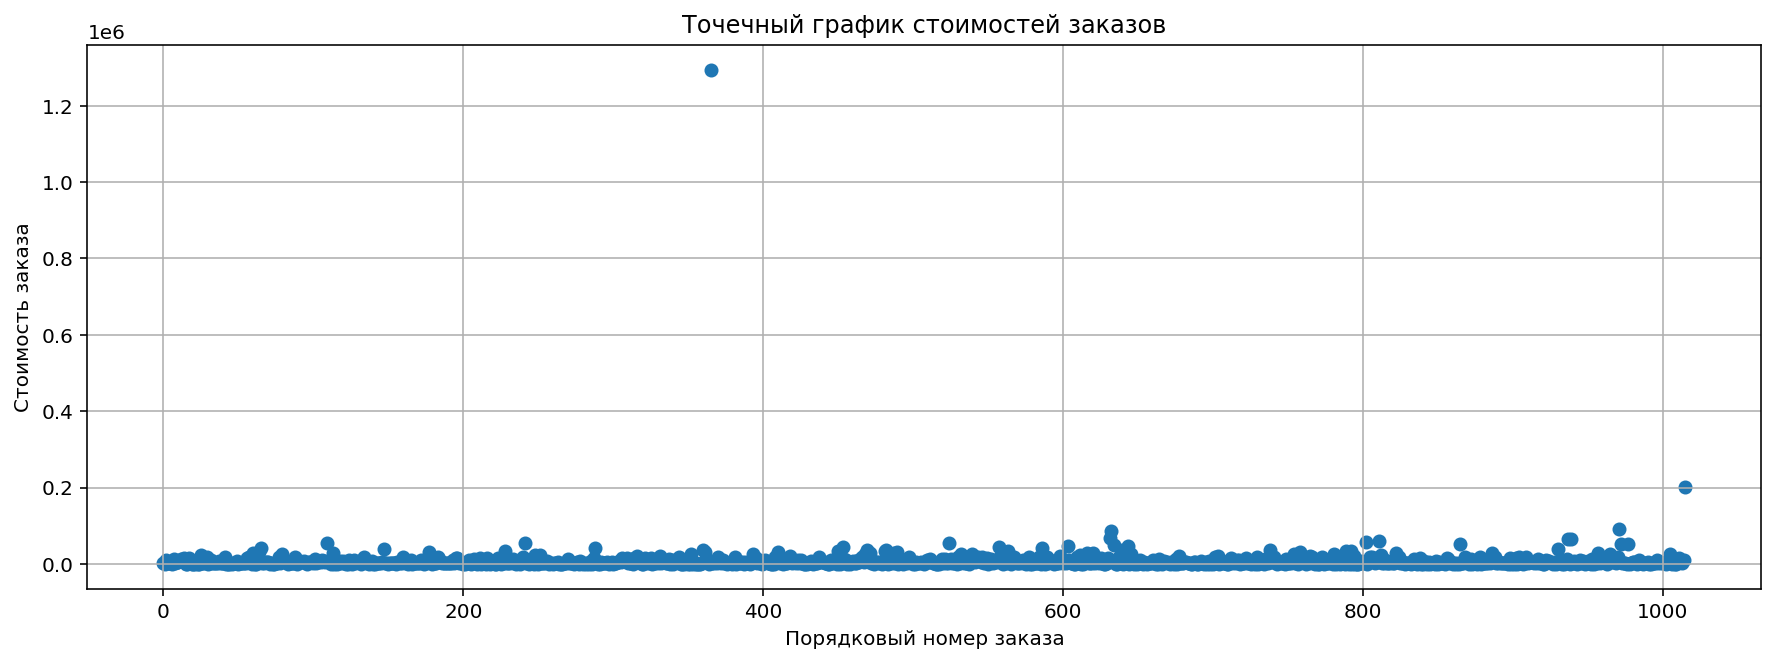

In [26]:
revenue_scatter = orders['revenue']

x_scatter = pd.Series(range(0, len(revenue_scatter)))

plt.figure(figsize=(15, 5))
plt.scatter(x_scatter, revenue_scatter)
plt.grid(True)
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость заказа')
plt.title('Точечный график стоимостей заказов');

Почти все заказы стоят меньше 200к денежных единиц, один стоит около 200к, также есть один аномально крупный заказ, цена которого составляет 1.2кк+  
  
Изучим 95 и 99 перцентили

In [27]:
np.percentile(revenue_scatter, [95, 99])

array([26785., 53904.])

Установим границу для определения аномалий на уровне 99 перцентиля, т.е. количество заказов <= 53904 будем считать нормальным

In [28]:
anomaly_revenue = np.percentile(revenue_scatter, 99)

### Проверка гипотез. Сырые данные

Создаем дополнительные переменные, они понадобятся для проверки гипотез

In [29]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

**Ho** - по сырым данным, количество заказов на посетителя в группе A **равно** количеству заказов на посетителя в группе B  
**H1** - по сырым данным, количество заказов на посетителя в группе A **не равно** количеству заказов на посетителя в группе B  
Уровень значимости **альфа** = 0.05

In [30]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05
res = stats.mannwhitneyu(sampleA, sampleB)[1]
diff = (sampleB.mean() / sampleA.mean() - 1)


if float(res) < alpha:
    print(f"{float(res):.3f} < {alpha} => можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")
else:
    print(f"{float(res):.3f} >= {alpha} => не можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")

0.011 < 0.05 => можем отвергнуть нулевую гипотезу. Разница между группами: 15.980%


По сырым данным **есть статистически значимое различие** по количеству заказов на посетителя между группами A и B. Разница между группами составляет ~**16%**.

**Ho** - по сырым данным, средний чек в группе A **равен** среднему чеку в группе B  
**H1** - по сырым данным, средний чек в группе A **не равен** среднему чеку в группе B  
Уровень значимости **альфа** = 0.05

In [31]:
alpha = 0.05
res = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
diff = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1

if float(res) < alpha:
    print(f"{float(res):.3f} < {alpha} => можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")
else:
    print(f"{float(res):.3f} >= {alpha} => не можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")

0.829 >= 0.05 => не можем отвергнуть нулевую гипотезу. Разница между группами: 28.660%


По сырым данным **нет статистически значимого различия** между средним чеком групп A и B, даже несмотря на то, что разница между группами составляет **28%**.

### Проверка гипотез. Очищенные данные

Создадим Series, который будет хранить в себе пользователей с аномально большим количеством заказов и аномально большими стоимостями заказа. Границы для определения аномалий мы уже определили выше.

In [32]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > anomaly_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > anomaly_orders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > anomaly_revenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Всего', abnormalUsers.shape[0], 'пользователей')

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
Всего 16 пользователей


**Ho** - по очищенным данным, количество заказов на посетителя в группе A **равно** количеству заказов на посетителя в группе B  
**H1** - по очищенным данным, количество заказов на посетителя в группе A **не равно** количеству заказов на посетителя в группе B  
Уровень значимости **альфа** = 0.05

In [33]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05
res = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
diff = sampleBFiltered.mean()/sampleAFiltered.mean()-1

if float(res) < alpha:
    print(f"{float(res):.3f} < {alpha} => можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")
else:
    print(f"{float(res):.3f} >= {alpha} => не можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")

0.007 < 0.05 => можем отвергнуть нулевую гипотезу. Разница между группами: 18.921%


По очищенным данным **есть статистически значимое различие** по количеству заказов на посетителя между группами A и B. Разница между группами составляет **~19%**, это больше, чем в сырых данных (16%).

**Ho** - по очищенным данным, средний чек в группе A **равен** среднему чеку в группе B  
**H1** - по очищенным данным, средний чек в группе A **не равен** среднему чеку в группе B  
Уровень значимости **альфа** = 0.05

In [34]:
res = (
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )


diff = (
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )


alpha = 0.05

if float(res) < alpha:
    print(f"{float(res):.3f} < {alpha} => можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")
else:
    print(f"{float(res):.3f} >= {alpha} => не можем отвергнуть нулевую гипотезу. Разница между группами: {float(diff)*100:.3f}%")

0.788 >= 0.05 => не можем отвергнуть нулевую гипотезу. Разница между группами: -3.234%


По очищенным данным **нет статистически значимого различия** между средним чеком групп A и B. В сырых данных разница между группами составляла 28%, после очистки от аномалий разница составляет **~-3%**.

### Выводы и рекомендации
  
1) **Есть статистически значимое различие по количеству заказов на пользователя** между группами как по сырым данным, так и после фильтрации аномалий.  
2) **Нет статистически значимого различия по среднему чеку** между группами как по сырым данным, так и после фильтрации аномалий.  
3) График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A сообщает, что **результаты группы B лучше, чем группы A**. Они зафиксировались около **среднего значения на уровне ~15%.**  

  
**Рекомендуется остановить тест, признать его успешным и перейти к проверке следующей гипотезы.**  
  
В процессе теста было выявлено **58 пользователей со 183 заказами,** которые попали одновременно в группы A и B. Необходимо разобраться, почему так вышло и постараться не допускать подобного в дальнейшем.